<a href="https://colab.research.google.com/github/nanecha/Insurance_Risk-Analysis_Predictive_Modelling/blob/main/notebookes/Sentiment_thematic_anlysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentimental and Thematic Analysis

In [ ]:
# importing of  Dependencies
#import dependencies
import pandas as pd
from google_play_scraper import reviews_all
import nltk
import spacy
from nltk.corpus import stopwords
from typing import List, Dict, Any
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import defaultdict


#sentiment analysis
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score


#keyword Extraction
from sklearn.feature_extraction.text import TfidfVectorizer

#visuals
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# New section

# Downloading the reviews of  banks

In [ ]:
# google play store bank app scraping
banks = [
    'com.combanketh.mobilebanking',  # Commercial Bank of Ethiopia
    'com.dashen.dashensuperapp',    # Dashen Bank
    'com.boa.boaMobileBanking'      # Bank of Abyssinia
]
all_reviews = []

*Collecting of Individuals banks (CBE,DASHEN and BOA)*

In [ ]:

def fetch_reviews(banks: List[str], max_reviews_per_bank: int = 400) -> List[Dict[str, Any]]:
    """
    Fetches app reviews with bank source tracking

    Args:
        banks: List of app package names (e.g., ["com.combanketh.mobilebanking", "com.dashen.dashensuperapp"])
        max_reviews_per_bank: Maximum reviews to fetch per app

    Returns:
        List of reviews, each annotated with its source bank
    """
    all_reviews = []

    for app_id in banks:
        try:
            # Map package name to bank display name
            if app_id == "com.combanketh.mobilebanking":
                bank_name = "Commercial Bank of Ethiopia"
            elif app_id == "com.dashen.dashensuperapp":
                bank_name = "Dashen Bank"
            else:
                bank_name = "Abyssinia Bank"

            # Fetch reviews with proper parameters
            reviews = reviews_all(
                app_id,
                sleep_milliseconds=100,  # Small delay to avoid rate limiting
                lang='en',
                country='us'
            )

            # Add bank identifier to each review
            for review in reviews[:max_reviews_per_bank]:
                review['App_id'] = app_id
                review['Bank'] = bank_name
                all_reviews.append(review)

            print(f"Fetched {len(reviews[:max_reviews_per_bank])} reviews from {bank_name}")

        except Exception as e:
            print(f"Failed to fetch {app_id}: {str(e)}")
            continue

    print(f"\nTOTAL REVIEWS: {len(all_reviews)}")
    return all_reviews

In [ ]:

if __name__ == "__main__":
    target_banks = ["com.combanketh.mobilebanking", "com.dashen.dashensuperapp","com.boa.boaMobileBanking"]
    reviews = fetch_reviews(target_banks)
    print(f"Final review count: {len(reviews)}")

Fetched 400 reviews from Commercial Bank of Ethiopia
Fetched 400 reviews from Dashen Bank
Fetched 400 reviews from Abyssinia Bank

TOTAL REVIEWS: 1200
Final review count: 1200


*Date Normalization*

In [ ]:
df=pd.DataFrame(reviews)
# Convert 'at' column to datetime
df['at'] = pd.to_datetime(df['at'], unit='ms')
df.head(10)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,App_id,Bank
0,2148bb53-1ab6-4d95-aa65-4786ae48ee4b,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,v.good app,4,0,None,2025-06-09 11:49:09,None,None,None,com.combanketh.mobilebanking,Commercial Bank of Ethiopia
1,02716b27-d785-403b-9171-44ae0eb5db90,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,very good app,1,0,None,2025-06-09 01:24:23,None,None,None,com.combanketh.mobilebanking,Commercial Bank of Ethiopia
2,44b56ef7-c297-438a-94ac-f59f70b40594,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Very amazing app indeed. I'm enjoying it,5,0,None,2025-06-08 21:52:23,None,None,None,com.combanketh.mobilebanking,Commercial Bank of Ethiopia
3,ba2970d7-802b-44d5-9c91-e6bed733adad,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Best,5,0,None,2025-06-08 18:25:37,None,None,None,com.combanketh.mobilebanking,Commercial Bank of Ethiopia
4,3e1d37a0-a082-4cb0-912a-8efff072ed3f,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,20 years,5,0,None,2025-06-08 12:04:48,None,None,None,com.combanketh.mobilebanking,Commercial Bank of Ethiopia
5,a7d1c799-ba53-4a0a-a8d6-c5400a009825,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,A great app. It's like carrying a bank in your...,4,0,5.1.0,2025-06-07 20:21:52,None,None,5.1.0,com.combanketh.mobilebanking,Commercial Bank of Ethiopia
6,64ed5562-1758-4eb8-9291-8b6edc394118,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,More than garrantty bank EBC.,4,0,None,2025-06-07 18:21:26,None,None,None,com.combanketh.mobilebanking,Commercial Bank of Ethiopia
7,d0c05687-ddd4-43fb-95a9-08f6358d80a2,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,really am happy to this app it is Siple to use...,5,0,5.1.0,2025-06-07 11:02:38,None,None,5.1.0,com.combanketh.mobilebanking,Commercial Bank of Ethiopia
8,811bf820-3529-433a-9b6d-e624fa23a16a,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,I liked this app. But the User interface is ve...,2,0,5.1.0,2025-06-07 10:50:29,None,None,5.1.0,com.combanketh.mobilebanking,Commercial Bank of Ethiopia
9,be2cb2ac-bbe0-4175-81c4-9f6c86afdaaa,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,"""Why don’t your ATMs support account-to-accoun...",4,0,None,2025-06-06 09:54:11,None,None,None,com.combanketh.mobilebanking,Commercial Bank of Ethiopia


#   Data preprocessing
*1. Column Rename fro clarity*

In [ ]:

#rename columns
df.rename(columns={
    'content': 'review_text',
    'score': 'rating',
    'at': 'review_date',
    'reviewId': 'review_id',
    'userName': 'userName'
}, inplace=True)
df['source'] = 'Google Play store'  # Adding the column to called the source= google play store

# Display after adjusting
df.head()


,review_id,userName,userImage,review_text,rating,thumbsUpCount,reviewCreatedVersion,review_date,replyContent,repliedAt,appVersion,App_id,Bank,source
0,2148bb53-1ab6-4d95-aa65-4786ae48ee4b,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,v.good app,4,0,None,2025-06-09 11:49:09,None,None,None,com.combanketh.mobilebanking,Commercial Bank of Ethiopia,Google Play store
1,02716b27-d785-403b-9171-44ae0eb5db90,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,very good app,1,0,None,2025-06-09 01:24:23,None,None,None,com.combanketh.mobilebanking,Commercial Bank of Ethiopia,Google Play store
2,44b56ef7-c297-438a-94ac-f59f70b40594,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Very amazing app indeed. I'm enjoying it,5,0,None,2025-06-08 21:52:23,None,None,None,com.combanketh.mobilebanking,Commercial Bank of Ethiopia,Google Play store
3,ba2970d7-802b-44d5-9c91-e6bed733adad,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Best,5,0,None,2025-06-08 18:25:37,None,None,None,com.combanketh.mobilebanking,Commercial Bank of Ethiopia,Google Play store
4,3e1d37a0-a082-4cb0-912a-8efff072ed3f,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,20 years,5,0,None,2025-06-08 12:04:48,None,None,None,com.combanketh.mobilebanking,Commercial Bank of Ethiopia,Google Play store


*2.Data cleaning (Drop of the duplicates reviews and handle the missing)*

In [ ]:

#handle duplicate reviews
df.drop_duplicates()
#print the duplicate reviews
#check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values)
#drop missing values
Missing_value=df.dropna()
#print the missing values
print(f"Total missing values removed: {len(Missing_value)}")


Missing values in each column:
review_id                  0
userName                   0
userImage                  0
review_text                0
rating                     0
thumbsUpCount              0
reviewCreatedVersion     287
review_date                0
replyContent            1200
repliedAt               1200
appVersion               287
App_id                     0
Bank                       0
source                     0
dtype: int64
Total missing values removed: 0


**3. Textual cleaning and related**

*Steps*:
* Clean text: Remove punctuation, special characters, convert to lowercase.
* Tokenize: Split text into words.
* Remove stop words: Eliminate common words (e.g., "the," "and").
* Lemmatize: Reduce words to base form (e.g., "running" → "run").

In [ ]:
def clean_review_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and special characters
    text = ''.join(char for char in text if char.isalnum() or char.isspace())
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)


In [ ]:

#Apply the cleaning function to the review_text column
df['cleaned_review_text'] = df['review_text'].apply(clean_review_text)
# Save the cleaned reviews to a new CSV file
df.to_csv('F:/Bank-Reviews-Analysis/Data/cleaned_data/All_bank_reviews_cleaned.csv', index=False, encoding='utf-8-sig')
print("First 10 rows of cleaned All bank reviews:")
print(df.head())

First 10 rows of cleaned All bank reviews:
                              review_id       userName  \
0  2148bb53-1ab6-4d95-aa65-4786ae48ee4b  A Google user   
1  02716b27-d785-403b-9171-44ae0eb5db90  A Google user   
2  44b56ef7-c297-438a-94ac-f59f70b40594  A Google user   
3  ba2970d7-802b-44d5-9c91-e6bed733adad  A Google user   
4  3e1d37a0-a082-4cb0-912a-8efff072ed3f  A Google user   

                                           userImage  \
0  https://play-lh.googleusercontent.com/EGemoI2N...   
1  https://play-lh.googleusercontent.com/EGemoI2N...   
2  https://play-lh.googleusercontent.com/EGemoI2N...   
3  https://play-lh.googleusercontent.com/EGemoI2N...   
4  https://play-lh.googleusercontent.com/EGemoI2N...   

                                review_text  rating  thumbsUpCount  \
0                                v.good app       4              0   
1                             very good app       1              0   
2  Very amazing app indeed. I'm enjoying it       5          

# Sentiment Analysis with TextBlob

Description: TextBlob provides a straightforward way to classify sentiments based on polarity scores.

In [ ]:
 # Function to analyze sentiment and return BOTH label and score
def analyze_sentiment_textblob(text):
    analysis = TextBlob(text)
    polarity = analysis.sentiment.polarity  # Get raw score (-1 to +1)
    # Assign sentiment label
    if polarity > 0:
        sentiment_label = 'positive'
    elif polarity < 0:
        sentiment_label = 'negative'
    else:
        sentiment_label = 'neutral'

    return sentiment_label, polarity  # Return both label and score


    # Apply the sentiment analysis function to the cleaned review text
    # Apply the function and create two columns
df[['Sentiment_label', 'Sentiment_score']] = df['cleaned_review_text'].apply(
    lambda x: pd.Series(analyze_sentiment_textblob(x))
)

# Print results
print("Sentiment analysis completed. Results:")
print("\nSentiment Distribution:")
print(df['Sentiment_label'].value_counts())
print("\nSentiment Score Statistics:")
print(df['Sentiment_score'].describe())


#df['textblob_sentiment'] = df['cleaned_review_text'].apply(analyze_sentiment_textblob)

#print("Sentiment analysis using TextBlob completed for all bank reviews.")
#print(df['textblob_sentiment'].value_counts())
#save the sentiment
df.to_csv('F:/Bank-Reviews-Analysis/Data/cleaned_data/All bank_reviews_sentiment_textblob.csv', index=False, encoding='utf-8-sig')

Sentiment analysis completed. Results:

Sentiment Distribution:
Sentiment_label
positive    763
neutral     323
negative    114
Name: count, dtype: int64

Sentiment Score Statistics:
count    1200.000000
mean        0.310072
std         0.405023
min        -1.000000
25%         0.000000
50%         0.294028
75%         0.700000
max         1.000000
Name: Sentiment_score, dtype: float64


In [ ]:
df.head()

,review_id,userName,userImage,review_text,rating,thumbsUpCount,reviewCreatedVersion,review_date,replyContent,repliedAt,appVersion,App_id,Bank,source,cleaned_review_text,Sentiment_label,Sentiment_score
0,2148bb53-1ab6-4d95-aa65-4786ae48ee4b,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,v.good app,4,0,None,2025-06-09 11:49:09,None,None,None,com.combanketh.mobilebanking,Commercial Bank of Ethiopia,Google Play store,vgood app,neutral,0.00
1,02716b27-d785-403b-9171-44ae0eb5db90,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,very good app,1,0,None,2025-06-09 01:24:23,None,None,None,com.combanketh.mobilebanking,Commercial Bank of Ethiopia,Google Play store,good app,positive,0.70
2,44b56ef7-c297-438a-94ac-f59f70b40594,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Very amazing app indeed. I'm enjoying it,5,0,None,2025-06-08 21:52:23,None,None,None,com.combanketh.mobilebanking,Commercial Bank of Ethiopia,Google Play store,amazing app indeed im enjoying,positive,0.55
3,ba2970d7-802b-44d5-9c91-e6bed733adad,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Best,5,0,None,2025-06-08 18:25:37,None,None,None,com.combanketh.mobilebanking,Commercial Bank of Ethiopia,Google Play store,best,positive,1.00
4,3e1d37a0-a082-4cb0-912a-8efff072ed3f,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,20 years,5,0,None,2025-06-08 12:04:48,None,None,None,com.combanketh.mobilebanking,Commercial Bank of Ethiopia,Google Play store,20 year,neutral,0.00


# Sentiment Analysis with VADER
Description: VADER is tailored for short texts like reviews, accounting for sentiment intensity and informal language.

In [ ]:
nltk.download('vader_lexicon')
# Initialize VADER
sia = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    scores = sia.polarity_scores(text)
    if scores['compound'] > 0.05:
        return 'positive'
    elif scores['compound'] < -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply VADER sentiment analysis
df['vader_sentiment'] = df['cleaned_review_text'].apply(get_vader_sentiment)

# Display sentiment distribution
print(df['vader_sentiment'].value_counts())

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


vader_sentiment
positive    771
neutral     304
negative    125
Name: count, dtype: int64


# Keyword Extraction with TF-IDF





Description: TF-IDF identifies words that are important in specific reviews relative to the entire dataset.

In [ ]:
# Vectorize the dataset
vectorizer = TfidfVectorizer(max_features=100)
X = vectorizer.fit_transform(df['cleaned_review_text'])

# Get top keywords
keywords = vectorizer.get_feature_names_out()
print("Top Keywords:", keywords)

Top Keywords: ['able' 'access' 'account' 'ahead' 'also' 'always' 'amazing' 'app'
 'application' 'apps' 'bad' 'bank' 'banking' 'best' 'better' 'boa' 'cant'
 'cbe' 'convenient' 'customer' 'dashen' 'developer' 'digital' 'doesnt'
 'dont' 'easy' 'even' 'ever' 'every' 'everything' 'excellent' 'experience'
 'fast' 'feature' 'financial' 'fix' 'friendly' 'get' 'give' 'good' 'great'
 'highly' 'im' 'issue' 'ive' 'keep' 'know' 'life' 'like' 'love' 'make'
 'many' 'mobile' 'money' 'much' 'need' 'never' 'new' 'nice' 'ok' 'one'
 'option' 'payment' 'phone' 'platform' 'please' 'problem' 'really'
 'reliable' 'say' 'screenshot' 'seamless' 'secure' 'security' 'service'
 'simple' 'slow' 'smooth' 'sometimes' 'step' 'super' 'take' 'thank' 'time'
 'transaction' 'transfer' 'try' 'turn' 'update' 'use' 'used' 'user'
 'userfriendly' 'using' 'version' 'work' 'working' 'worst' 'wow' 'ነው']


# Combining Sentiment Analysis and Keyword Extractio
Description: Analyze keywords in positive vs. negative reviews to understand user preferences and issues.

In [ ]:
# Function for filter
# Filter positive and negative reviews
positive_reviews = df[df['vader_sentiment'] == 'positive']['cleaned_review_text']
negative_reviews = df[df['vader_sentiment'] == 'negative']['cleaned_review_text']

# Extract keywords from positive reviews
vectorizer_pos = TfidfVectorizer(max_features=10)
X_pos = vectorizer_pos.fit_transform(positive_reviews)
print("Top Keywords in Positive Reviews:", vectorizer_pos.get_feature_names_out())

# Extract keywords from negative reviews
vectorizer_neg = TfidfVectorizer(max_features=10)
X_neg = vectorizer_neg.fit_transform(negative_reviews)
print("Top Keywords in Negative Reviews:", vectorizer_neg.get_feature_names_out())

Top Keywords in Positive Reviews: ['app' 'bank' 'banking' 'best' 'dashen' 'easy' 'good' 'nice' 'super' 'use']
Top Keywords in Negative Reviews: ['app' 'bad' 'bank' 'banking' 'even' 'ever' 'fix' 'time' 'work' 'worst']


#  Thematic Analysis

In [ ]:
#first initialize the ThematicAnalyzer class
class ThematicAnalyzer:
    def __init__(self):
        self.nlp = spacy.load("en_core_web_sm")
    def cluster_themes(self, reviews: pd.DataFrame) -> Dict[str, List[str]]:
        # Rule-based clustering example
        theme_rules = {
            "Account Access": ["login", "password", "account", "access","security"],
            "Transactions": ["transfer", "send", "payment", "transaction","money"],
            "UI/UX": ["interface", "design", "screen", "button","screenshot"],
            "Customer Support": ["support", "service", "response", "help","need"],
            "Performance": ["slow", "crash", "lag", "speed","best"]
        }

        themes = defaultdict(list)
        for _, row in reviews.iterrows():
            doc = self.nlp(row["cleaned_review_text"])
            found_themes = set()

            for token in doc:
                for theme, keywords in theme_rules.items():
                    if token.lemma_ in keywords and theme not in found_themes:
                        themes[row["cleaned_review_text"]].append(theme)
                        found_themes.add(theme)

        return themes



# 3. Initialize analyzer and call the function
analyzer = ThematicAnalyzer()
theme_mapping = analyzer.cluster_themes(df)

# 4. Add themes back to original DataFrame
df["themes"] = df["cleaned_review_text"].map(theme_mapping)

df.tail(10)




,review_id,userName,userImage,review_text,rating,thumbsUpCount,reviewCreatedVersion,review_date,replyContent,repliedAt,appVersion,App_id,Bank,source,cleaned_review_text,Sentiment_label,Sentiment_score,themes
1190,2a2d15cb-06ba-425c-a417-2f020e552505,negus _,https://play-lh.googleusercontent.com/a-/ALV-U...,Crashes very frequently is not stable overall ...,1,1,24.05.07,2024-07-19 09:35:32,None,None,24.05.07,com.boa.boaMobileBanking,Abyssinia Bank,Google Play store,crash frequently stable overall need improveme...,positive,0.200000,"[Performance, Customer Support]"
1191,a6914442-d04b-4b79-bf2e-362f73c09160,ተመሥገን ምትኩ,https://play-lh.googleusercontent.com/a-/ALV-U...,ርይርፍ,3,0,24.02.07,2024-07-19 08:11:01,None,None,24.02.07,com.boa.boaMobileBanking,Abyssinia Bank,Google Play store,ርይርፍ,neutral,0.000000,[]
1192,d7ee5d77-4c89-4e81-a79d-000f5e23c3ac,eyob mikire,https://play-lh.googleusercontent.com/a-/ALV-U...,The previous application is much better than t...,1,0,24.07.04,2024-07-18 17:40:55,None,None,24.07.04,com.boa.boaMobileBanking,Abyssinia Bank,Google Play store,previous application much better one,positive,0.166667,[]
1193,29aa3b3c-e4c7-41c7-bbb1-5d514633c307,Hailemichael Melaku,https://play-lh.googleusercontent.com/a-/ALV-U...,Worst app. It is wise to invest money and you ...,1,0,None,2024-07-18 11:45:25,None,None,None,com.boa.boaMobileBanking,Abyssinia Bank,Google Play store,worst app wise invest money make like cbe app ...,positive,0.075000,[Transactions]
1194,f7d047c8-6354-4ab4-8960-83463815f833,Maxamud Roble,https://play-lh.googleusercontent.com/a-/ALV-U...,mal,5,1,24.07.04,2024-07-16 23:55:56,None,None,24.07.04,com.boa.boaMobileBanking,Abyssinia Bank,Google Play store,mal,neutral,0.000000,[]
1195,b1ec9a7a-5962-45c7-ac3a-0043f8a96f9e,Mariyam Amalaje,https://play-lh.googleusercontent.com/a/ACg8oc...,It is not working at all,1,0,24.07.04,2024-07-16 20:29:37,None,None,24.07.04,com.boa.boaMobileBanking,Abyssinia Bank,Google Play store,working,neutral,0.000000,[]
1196,37ed81e2-a945-49be-b1fb-0527a4f8a21d,bekri Emam,https://play-lh.googleusercontent.com/a-/ALV-U...,Excellent,5,1,24.07.04,2024-07-16 19:57:45,None,None,24.07.04,com.boa.boaMobileBanking,Abyssinia Bank,Google Play store,excellent,positive,1.000000,[]
1197,95a7177d-a323-4a17-98ad-9f94ea147686,Israel Tsegaye,https://play-lh.googleusercontent.com/a-/ALV-U...,The poorest mobile banking survice ever. Only ...,1,0,24.07.04,2024-07-16 16:37:32,None,None,24.07.04,com.boa.boaMobileBanking,Abyssinia Bank,Google Play store,poorest mobile banking survice ever error repo...,positive,0.100000,[]
1198,4a6a938a-e74a-4e00-81f8-76c8b093f4d3,Ephrem Hagos,https://play-lh.googleusercontent.com/a/ACg8oc...,Wow,5,1,24.07.04,2024-07-16 13:01:39,None,None,24.07.04,com.boa.boaMobileBanking,Abyssinia Bank,Google Play store,wow,positive,0.100000,[]
1199,e40abcb7-e431-4333-92ad-ef90b6cb11cb,Addis Alem,https://play-lh.googleusercontent.com/a-/ALV-U...,😞😞😞😞,1,0,24.07.04,2024-07-16 00:13:22,None,None,24.07.04,com.boa.boaMobileBanking,Abyssinia Bank,Google Play store,,neutral,0.000000,[]


# Sentimental Analysis By Bank and Rating

In [ ]:
#sentimental Analysis by
# Sentiment by bank and rating
report = df.groupby(["Bank", "rating"])["Sentiment_score"].mean().unstack()
print("\nSentiment Analysis Report:")
print(report)




Sentiment Analysis Report:
rating                              1         2         3         4         5
Bank                                                                         
Abyssinia Bank              -0.081035  0.162121  0.157219  0.318320  0.426596
Commercial Bank of Ethiopia  0.004580  0.139328  0.206600  0.377760  0.476003
Dashen Bank                  0.092545  0.005308  0.256278  0.327278  0.417663


# Visualizing the Results

**Visualizations**:
* Bar Chart: Show the distribution of positive, negative, and neutral sentiments.
* Word Cloud: Visualize frequent keywords in positive and negative reviews

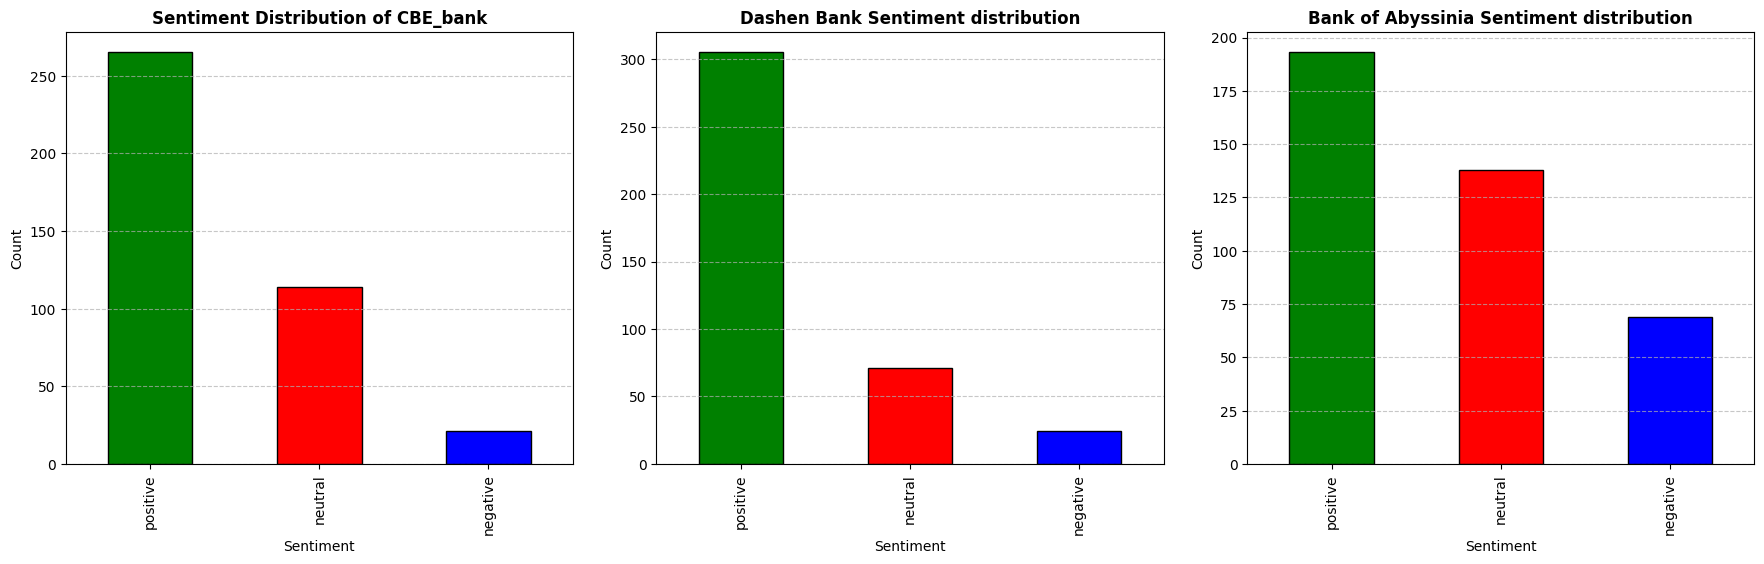

In [ ]:


# Prepare the data
CBE_bank = df.iloc[:400]
DA_Bank = df.iloc[400:800]
BOA_bank = df.iloc[800:1200]

# Create a single figure with 3 side-by-side subplots
plt.figure(figsize=(18, 6))  # Wider figure for better spacing
# --- CBE Bank Sentiment (Left) ---
plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st subplot
CBE_bank['Sentiment_label'].value_counts().plot(kind='bar', color=['green', 'red', 'blue'],edgecolor='black') # Optional: adds borders to bars
plt.title('Sentiment Distribution of CBE_bank', fontweight='bold')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Optional: adds horizontal grid lines
# --- Dashen Bank Sentiment (Middle) ---
plt.subplot(1, 3, 2)
DA_Bank['Sentiment_label'].value_counts().plot(kind='bar', color=['green', 'red', 'blue'], edgecolor='black')
plt.title('Dashen Bank Sentiment distribution', fontweight='bold')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
# --- BOA Bank Sentiment (Right) ---
plt.subplot(1, 3, 3)
BOA_bank['Sentiment_label'].value_counts().plot(kind='bar', color=['green', 'red', 'blue'],edgecolor='black')
plt.title('Bank of Abyssinia Sentiment distribution', fontweight='bold')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Adjust layout and display
plt.tight_layout(pad=2.0)  # Adds padding between subplots
plt.show()

# word cloud for Positive reviews

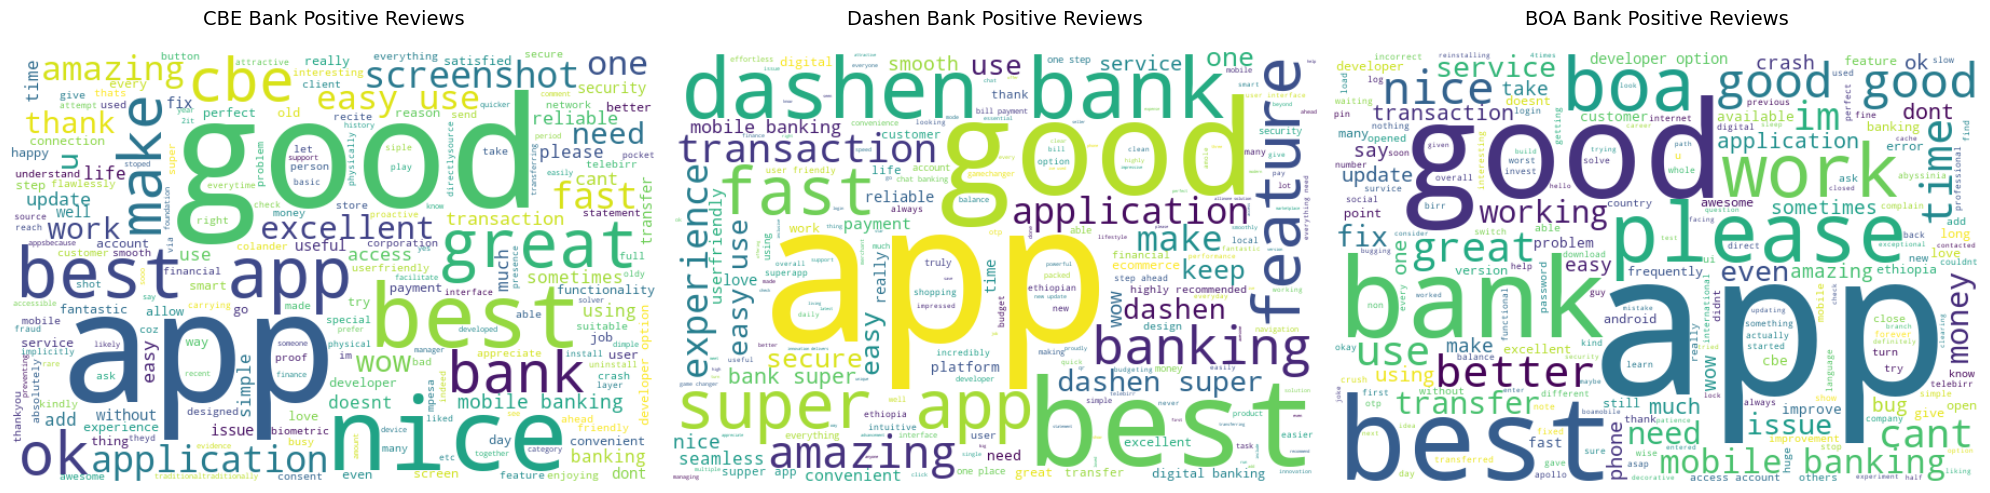

In [ ]:
# --- CBE Word Cloud ---
plt.figure(figsize=(20, 20))  # Wider figure for 3 subplots
plt.subplot(1, 3, 1)  # 1 row, 3 cols, position 1
cbe_positive_reviews = CBE_bank[CBE_bank['Sentiment_label'] == 'positive']['cleaned_review_text']
cbe_text = ' '.join(cbe_positive_reviews)
wordcloud = WordCloud(width=600, height=400, background_color='white').generate(cbe_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('CBE Bank Positive Reviews', fontsize=14, pad=20)

# --- Dashen Word Cloud ---
dashen_positive_reviews = DA_Bank[DA_Bank['Sentiment_label'] == 'positive']['cleaned_review_text']
plt.subplot(1, 3, 2)
dashen_text = ' '.join(dashen_positive_reviews)
wordcloud = WordCloud(width=600, height=400, background_color='white').generate(dashen_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Dashen Bank Positive Reviews', fontsize=14, pad=20)

# --- BOA Word Cloud ---
boa_positive_reviews = BOA_bank[BOA_bank['Sentiment_label'] == 'positive']['cleaned_review_text']
plt.subplot(1, 3, 3)
boa_text = ' '.join(boa_positive_reviews)
wordcloud = WordCloud(width=600, height=400, background_color='white').generate(boa_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('BOA Bank Positive Reviews', fontsize=14, pad=20)

plt.tight_layout()  # Prevent overlapping
plt.show()

In [ ]:
 # Word cloud for positive reviews
positive_text = ' '.join(positive_reviews)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

# Final Result  CSV file for oracle Database

In [ ]:
df.to_csv('F:/Bank-Reviews-Analysis/Data/cleaned_data/All bank_reviews_final.csv', index=False, encoding='utf-8-sig')

df.head(10)

,review_id,userName,userImage,review_text,rating,thumbsUpCount,reviewCreatedVersion,review_date,replyContent,repliedAt,appVersion,App_id,Bank,source,cleaned_review_text,Sentiment_label,Sentiment_score,themes
0,2148bb53-1ab6-4d95-aa65-4786ae48ee4b,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,v.good app,4,0,None,2025-06-09 11:49:09,None,None,None,com.combanketh.mobilebanking,Commercial Bank of Ethiopia,Google Play store,vgood app,neutral,0.000000,[]
1,02716b27-d785-403b-9171-44ae0eb5db90,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,very good app,1,0,None,2025-06-09 01:24:23,None,None,None,com.combanketh.mobilebanking,Commercial Bank of Ethiopia,Google Play store,good app,positive,0.700000,[]
2,44b56ef7-c297-438a-94ac-f59f70b40594,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Very amazing app indeed. I'm enjoying it,5,0,None,2025-06-08 21:52:23,None,None,None,com.combanketh.mobilebanking,Commercial Bank of Ethiopia,Google Play store,amazing app indeed im enjoying,positive,0.550000,[]
3,ba2970d7-802b-44d5-9c91-e6bed733adad,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Best,5,0,None,2025-06-08 18:25:37,None,None,None,com.combanketh.mobilebanking,Commercial Bank of Ethiopia,Google Play store,best,positive,1.000000,[]
4,3e1d37a0-a082-4cb0-912a-8efff072ed3f,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,20 years,5,0,None,2025-06-08 12:04:48,None,None,None,com.combanketh.mobilebanking,Commercial Bank of Ethiopia,Google Play store,20 year,neutral,0.000000,[]
5,a7d1c799-ba53-4a0a-a8d6-c5400a009825,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,A great app. It's like carrying a bank in your...,4,0,5.1.0,2025-06-07 20:21:52,None,None,5.1.0,com.combanketh.mobilebanking,Commercial Bank of Ethiopia,Google Play store,great app like carrying bank pocket,positive,0.800000,[]
6,64ed5562-1758-4eb8-9291-8b6edc394118,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,More than garrantty bank EBC.,4,0,None,2025-06-07 18:21:26,None,None,None,com.combanketh.mobilebanking,Commercial Bank of Ethiopia,Google Play store,garrantty bank ebc,neutral,0.000000,[]
7,d0c05687-ddd4-43fb-95a9-08f6358d80a2,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,really am happy to this app it is Siple to use...,5,0,5.1.0,2025-06-07 11:02:38,None,None,5.1.0,com.combanketh.mobilebanking,Commercial Bank of Ethiopia,Google Play store,really happy app siple use everything,positive,0.800000,[]
8,811bf820-3529-433a-9b6d-e624fa23a16a,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,I liked this app. But the User interface is ve...,2,0,5.1.0,2025-06-07 10:50:29,None,None,5.1.0,com.combanketh.mobilebanking,Commercial Bank of Ethiopia,Google Play store,liked app user interface basic attractive,positive,0.466667,[UI/UX]
9,be2cb2ac-bbe0-4175-81c4-9f6c86afdaaa,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,"""Why don’t your ATMs support account-to-accoun...",4,0,None,2025-06-06 09:54:11,None,None,None,com.combanketh.mobilebanking,Commercial Bank of Ethiopia,Google Play store,dont atm support accounttoaccount transfer lik...,neutral,0.000000,"[Customer Support, Transactions]"
